# EE4211 Data Science for IoT: Project

## Team Number: 23

Team Members:
1. Tan Kai Xin, Nicole (A0237969E)
2. Erik Naeslund (A0307005W)
3. Peng Ziwei (A0279207X)

## Question 3.1

At this point, you understand the data well. For your group proposed project, you must explore some aspects of machine learning models. You must use the dataset given but you may use additional datasets to supplement your analysis (eg. weather data), look at unaggregated data, look at the difference in carpark availability for carparks with free parking, etc. Note that you are not limited to the initial proposal and are free to expand on it.ility

### Datasets Used:

1. Rainfall Across Singapore (Data by National Environment Agency NEA)

https://data.gov.sg/datasets?page=1&query=rainfall&resultId=d_6580738cdd7db79374ed3152159fbd69

2. Ultraviolet Index (UVI) (Data by National Environment Agency NEA)

https://data.gov.sg/datasets?query=UVI&page=1&resultId=d_1b676cd174a9af4704fdb3f9aa58ff5e

3. Taxi Availability (Data by Land Transport Authority LTA)

https://data.gov.sg/datasets?page=1&query=Taxi&resultId=d_e25662f1a062dd046453926aa284ba64#tag/default/GET/transport/taxi-availability

4. Carpark Availability (Data by Housing and Development Board HDB)

https://data.gov.sg/datasets?query=Carpark+Availability+Data&page=1&resultId=d_ca933a644e55d34fe21f28b8052fac63#tag/default/GET/transport/carpark-availability

### Aim of Project

**Predict Taxi Availability August 2024 in Singapore based on historical July 2024 Rainfall, UV Index, Carpark Availability and Taxi Availability Datasets.**

### Approach

1. Extract Datasets required from data.gov.sg for the relevant time period of July 2024 and August 2024
2. Model the relationship between Rainfall Data and Taxi Availability
3. Model the relationship between UV Index Data and Taxi Availability
4. Model the relationship between Carpark Availability and Taxi Availability
5. Develop a model to model the relationship between all 3 datasets and Taxi Availabilty

## 1. Data Extraction

### Rainfall Data Extraction

Information on rainfall data, rainfall amount is collected based on various weather stations, stationed across Singapore. Rainfall data is collected and updated to the database every 5 min. For simplicity, we will sum up the total rainfall amount across all weather stations every 5 min, and average out the total rainfall amount according to the number of weather stations collecting the rainfall data during that 5 min duration (this is because the number of weather stations is not static, but dynamic, and their numbers consistently changes throughout the day). This average rainfall per weather station every 5 min, is then summed up every hour to develop an hourly dataset for use.

In [ ]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd

In [ ]:
def get_rainfall(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    url = f"https://api-open.data.gov.sg/v2/real-time/api/rainfall?date={year}-{month}-{day}T{hour}:{minute}:{second}"
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Data Extracted for {year}-{month}-{day}T{hour}:{minute}:{second}")
        return response.json()
    else:
        print(f"Error fetching data: {response.status_code} for {year}-{month}-{day}T{hour}:{minute}:{second}")
        return None

In [ ]:
def get_rainfall(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    url = f"https://api-open.data.gov.sg/v2/real-time/api/rainfall?date={year}-{month}-{day}T{hour}:{minute}:{second}"
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Data Extracted for {year}-{month}-{day}T{hour}:{minute}:{second}")
        return response.json()
    else:
        print(f"Error fetching data: {response.status_code} for {year}-{month}-{day}T{hour}:{minute}:{second}")
        return None

In [ ]:
def count_rainfall_stations(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    url = f"https://api-open.data.gov.sg/v2/real-time/api/rainfall?date={year}-{month}-{day}T{hour}:{minute}:{second}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if 'data' in data and 'stations' in data['data']:
            station_count = len(data['data']['stations'])
            print(f"Number of rainfall stations on {year}-{month}-{day}T{hour}:{minute}:{second}: {station_count}")
            return station_count
        else:
            print("Stations data not found in the response.")
            return None
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")
        return None

In [ ]:
def get_avg_rainfall_hourly(year, month, day, hour, minute, second):
    timestamp = f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)}T{str(hour).zfill(2)}:00:00"
    interval = 5
    max_interval = 12
    current_interval = 0

    total_hourly_rainfall = 0
    
    print('######################################################################')
    while current_interval < max_interval:
        print('######################################################################')
        timestamp_interval = f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)}T{str(hour).zfill(2)}:{str(int(current_interval * interval)).zfill(2)}:00"
        rainfall_data = get_rainfall(year, month, day, hour, int(current_interval * interval), second)
        station_numbers = count_rainfall_stations(year, month, day, hour, int(current_interval * interval), second)
        
        if rainfall_data is None or station_numbers is None:
            print(f"Error fetching data for {timestamp} at interval {current_interval * interval} minutes.")
            print('######################################################################')
            print('######################################################################')
            return timestamp, "Error"

        if 'data' in rainfall_data and 'readings' in rainfall_data['data']:
            readings = rainfall_data['data']['readings'][0]['data']
            total_rainfall_per_interval = sum(reading['value'] for reading in readings)
            avg_rainfall_per_interval = total_rainfall_per_interval / station_numbers
            print(f"Average Rainfall Per Weather Station on {timestamp_interval}: {avg_rainfall_per_interval}")
            total_hourly_rainfall += avg_rainfall_per_interval

        current_interval += 1
        time.sleep(1)
    
    print('######################################################################')
    print('######################################################################')
    print(f"Total Hourly Rainfall Per Weather Station on {timestamp}: {total_hourly_rainfall}")
    return timestamp, total_hourly_rainfall

# print(get_avg_rainfall_hourly(2024, 7, 1, 12, 0, 0))
# print(get_avg_rainfall_hourly(2024, 7, 1, 13, 0, 0))

In [ ]:
def process_rainfall_for_date_range(start_date, end_date, filename):
    """
    Process rainfall data for the specified date range and save results to a CSV file.
    
    Parameters:
        start_date (str): Start date in the format "YYYY-MM-DD".
        end_date (str): End date in the format "YYYY-MM-DD".
        filename (str): Output CSV file name.
    """
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d")
    
    current_datetime = start_datetime
    data_to_store = []

    while current_datetime <= end_datetime:
        year = current_datetime.year
        month = current_datetime.month
        day = current_datetime.day
        for hour in range(24): 
            timestamp, total_hourly_rainfall = get_avg_rainfall_hourly(year, month, day, hour, 0, 0)
            data_to_store.append({
                "timestamp": timestamp,
                "total_hourly_rainfall": total_hourly_rainfall
            })
        current_datetime += timedelta(days=1)

    df = pd.DataFrame(data_to_store)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

In [ ]:
process_rainfall_for_date_range("2024-07-01", "2024-07-06", "july_rainfall1_data.csv")
process_rainfall_for_date_range("2024-07-07", "2024-07-12", "july_rainfall2_data.csv")
process_rainfall_for_date_range("2024-07-13", "2024-07-18", "july_rainfall3_data.csv")
process_rainfall_for_date_range("2024-07-19", "2024-07-24", "july_rainfall4_data.csv")
process_rainfall_for_date_range("2024-07-25", "2024-07-31", "july_rainfall5_data.csv")

In [ ]:
process_rainfall_for_date_range("2024-08-01", "2024-08-06", "august_rainfall1_data.csv")
process_rainfall_for_date_range("2024-08-07", "2024-08-12", "august_rainfall2_data.csv")
process_rainfall_for_date_range("2024-08-13", "2024-08-18", "august_rainfall3_data.csv")
process_rainfall_for_date_range("2024-08-19", "2024-08-24", "august_rainfall4_data.csv")
process_rainfall_for_date_range("2024-08-25", "2024-08-31", "august_rainfall5_data.csv")

In [ ]:
file_paths = [
    "july_rainfall1_data.csv",
    "july_rainfall2_data.csv",
    "july_rainfall3_data.csv",
    "july_rainfall4_data.csv",
    "july_rainfall5_data.csv",
]

dataframes = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

full_july_rainfall_data = pd.concat(dataframes, ignore_index=True)

final_output_path = "july_rainfall_data.csv"
full_july_rainfall_data.to_csv(final_output_path, index=False)

final_output_path

In [ ]:
file_paths = [
    "august_rainfall1_data.csv",
    "august_rainfall2_data.csv",
    "august_rainfall3_data.csv",
    "august_rainfall4_data.csv",
    "august_rainfall5_data.csv",
]

dataframes = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

full_july_rainfall_data = pd.concat(dataframes, ignore_index=True)

final_output_path = "august_rainfall_data.csv"
full_july_rainfall_data.to_csv(final_output_path, index=False)

final_output_path

### UV Index Data Extraction

UV Index Data is collected every hour from 7am to 7pm. Due to the period from 7pm to 7am, we will assume that the UV Index during that period of time is 0.

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import requests

july_start = datetime(2024, 7, 1)
july_end = datetime(2024, 7, 31)
august_start = datetime(2024, 8, 1)
august_end = datetime(2024, 8, 31)

base_url = "https://api-open.data.gov.sg/v2/real-time/api/uv"

def get_uv_data(start_date, end_date):
    all_hours = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='h', tz='Asia/Singapore')[:-1]
    df = pd.DataFrame({"Hour": all_hours})
    df['Hour'] = df['Hour'].dt.tz_localize(None)
    df['UV Index'] = None
    
    current_date = start_date
    while current_date <= end_date:

        date_str = current_date.strftime('%Y-%m-%d')
        
        response = requests.get(base_url, params={"date": date_str})
        response_data = response.json()
        
        if response_data.get("code") == 0:
            records = response_data.get("data", {}).get("records", [])
            
            for record in records:
                for index in record.get("index", []):
                    hour = index.get("hour")
                    value = index.get("value")
                    
                    hour_dt = pd.to_datetime(hour).tz_convert('Asia/Singapore').tz_localize(None)
                    
                    df.loc[df['Hour'] == hour_dt, 'UV Index'] = value
        
        current_date += timedelta(days=1)
    
    df['UV Index'] = df['UV Index'].fillna(0)
    return df

july_df = get_uv_data(july_start, july_end)
july_df.to_csv("UV_index_July_2024.csv", index=False)
print("July data saved to UV_index_July_2024.csv")

august_df = get_uv_data(august_start, august_end)
august_df.to_csv("UV_index_August_2024.csv", index=False)
print("August data saved to UV_index_August_2024.csv")

In [ ]:
print(len(august_df))
print(len(july_df))

In [ ]:
import matplotlib.pyplot as plt
def plot_uv_index(dataframe, title):
    
    dataframe['Hour'] = pd.to_datetime(dataframe['Hour'])
    
    plt.figure(figsize=(12, 6))
    plt.plot(dataframe['Hour'], dataframe['UV Index'], label="UV Index", linewidth=1)
    plt.title(title, fontsize=16)
    plt.xlabel("Date and Time", fontsize=12)
    plt.ylabel("UV Index", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

#plot_uv_index(july_df, "UV Index for July 2024")
#plot_uv_index(august_df, "UV Index for August 2024")

### Taxi Availability Data Extraction

In [ ]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/taxi-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "features" in data and len(data["features"]) > 0:
            print(f"Data retrieved successfully for {year}-{month}-{day} {hour}:{minute}:{second}")
            return data["features"][0]["properties"]["taxi_count"]
            # return data
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None, None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code} for {year}-{month}-{day} {hour}:{minute}:{second}")
        return None, None

In [ ]:
def generate_timestamps(start_date, end_date, interval):
    return [start_date + timedelta(minutes=interval * i) 
            for i in range(int((end_date - start_date).total_seconds() // (interval * 60)) + 1)]

In [ ]:
def process_data(start_date, end_date, interval, data_fetcher):
    timestamps = generate_timestamps(start_date, end_date, interval)
    data_collected = []
    
    for timestamp in timestamps:
        taxi_count = data_fetcher(timestamp.year, timestamp.month, timestamp.day, 
                                    timestamp.hour, timestamp.minute, timestamp.second)
        
        data_collected.append((timestamp, taxi_count))
    
    df = pd.DataFrame(data_collected, columns=['Timestamp', 'Taxi Availability']).drop_duplicates(subset='Timestamp')
    
    df.set_index('Timestamp', inplace=True)
    
    df['Taxi Availability'] = df['Taxi Availability'].interpolate(method='cubic')
    
    return df

In [ ]:
start_july = datetime(2024, 7, 1, 0, 0, 0)
end_july = datetime(2024, 7, 31, 23, 59, 59)
start_august = datetime(2024, 8, 1, 0, 0, 0)
end_august = datetime(2024, 8, 31, 23, 59, 59)
interval = 20

def resample_to_hourly_average(df):
    hourly_df = df.resample('1H').mean()
    return hourly_df

july_data_df = process_data(start_july, end_july, interval, fetch_data_for_time)
july_data_hourly_df = resample_to_hourly_average(july_data_df)
july_data_hourly_df.to_csv('july_2024_taxi_availability_hourly.csv', index=True)

august_data_df = process_data(start_august, end_august, interval, fetch_data_for_time)
august_data_hourly_df = resample_to_hourly_average(august_data_df)
august_data_hourly_df.to_csv('august_2024_taxi_availability_hourly.csv', index=True)

In [ ]:
def load_interpolate_save(input_file, output_file):

    df = pd.read_csv(input_file, parse_dates=['Timestamp'], index_col='Timestamp')
    
    df['Taxi Availability'] = df['Taxi Availability'].interpolate(method='cubic')
    
    df.to_csv(output_file, index=True)
    
    return df

july_data_df = load_interpolate_save('july_2024_taxi_availability_hourly.csv', 'july_2024_taxi_availability_interpolated.csv')
august_data_df = load_interpolate_save('august_2024_taxi_availability_hourly.csv', 'august_2024_taxi_availability_interpolated.csv')
july_data_df = july_data_df.reset_index()
august_data_df = august_data_df.reset_index()

print("After resetting index:")
print("July DataFrame head:\n", july_data_df.head())
print("August DataFrame head:\n", august_data_df.head())

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(july_data_df['Timestamp'], july_data_df['Taxi Availability'], label="Average Taxi Availability (Interpolated)")
plt.xlabel("Date Time")
plt.ylabel("Taxi Availability")
plt.title("Hourly Taxi Availability for July 2024 (Interpolated)")
plt.grid(True)
plt.xticks(july_data_df['Timestamp'][::24], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(august_data_df['Timestamp'], august_data_df['Taxi Availability'], label="Average Taxi Availability (Interpolated)")
plt.xlabel("Date Time")
plt.ylabel("Taxi Availability")
plt.title("Hourly Taxi Availability for August 2024 (Interpolated)")
plt.grid(True)
plt.xticks(august_data_df['Timestamp'][::24], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## 2. Modelling Relationships Between Taxi Availabilty & Various Datasets

In [1]:
import time
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import scipy.stats as stats
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr, spearmanr
import random
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Modelling Relationship Between Taxi Availability & Rainfall Dataset

In [33]:
rainfall_july = pd.read_csv('july_rainfall_data.csv')
rainfall_july['timestamp'] = pd.to_datetime(rainfall_july['timestamp'])

rainfall_august = pd.read_csv('august_rainfall_data.csv')
rainfall_august['timestamp'] = pd.to_datetime(rainfall_august['timestamp'])

taxi_july = pd.read_csv('july_2024_taxi_availability_interpolated.csv')
taxi_july['Timestamp'] = pd.to_datetime(taxi_july['Timestamp'])

taxi_august = pd.read_csv('august_2024_taxi_availability_interpolated.csv')
taxi_august['Timestamp'] = pd.to_datetime(taxi_august['Timestamp'])

In [34]:
X_train = np.array(rainfall_july['total_hourly_rainfall']).reshape(-1, 1)
X_test = np.array(rainfall_august['total_hourly_rainfall']).reshape(-1, 1)
y_train = np.array(taxi_july['Taxi Availability']).reshape(-1, 1)
y_test = np.array(taxi_august['Taxi Availability']).reshape(-1, 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [35]:
mlp = MLPRegressor(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)], 
    'activation': ['relu', 'tanh'],                           
    'solver': ['adam', 'sgd'],                               
    'learning_rate_init': [0.001, 0.01, 0.1]                  
}

In [36]:
grid_search = GridSearchCV(
    MLPRegressor(max_iter=500, random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10
)

grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_mlp = grid_search.best_estimator_

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.1, 'solver': 'adam'}


In [37]:
print("Best parameters:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_
y_pred = scaler.inverse_transform(best_mlp.predict(X_test_scaled).reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test data:", mse)
r2 = r2_score(y_test, y_pred)
print("R^2 Score:",r2)

Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.1, 'solver': 'adam'}
Mean Squared Error on test data: 271570.76408446964
R^2 Score: -0.16005477460987816


In [38]:
pearson_corr_rainfall, _ = pearsonr(y_test.ravel(), y_pred.ravel())
spearman_corr_rainfall, _ = spearmanr(y_test.ravel(), y_pred.ravel())

print("Rainfall Dataset:")
print("Pearson Correlation:", pearson_corr_rainfall)
print("Spearman Correlation:", spearman_corr_rainfall)

Rainfall Dataset:
Pearson Correlation: 0.0885484202843071
Spearman Correlation: 0.1315889310780184


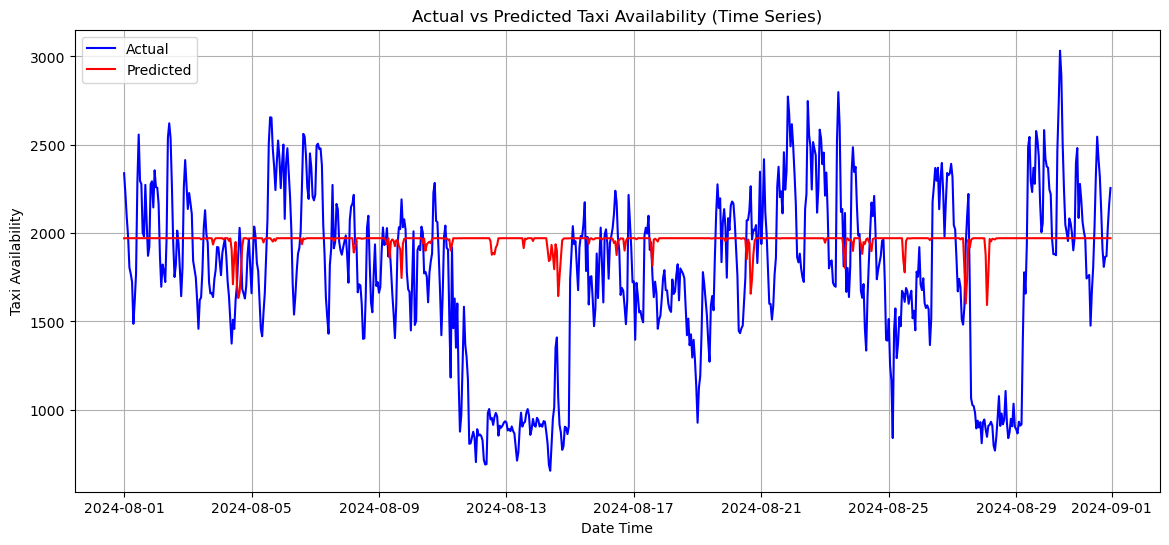

In [39]:
plt.figure(figsize=(14, 6))
plt.plot(taxi_august['Timestamp'], y_test, label='Actual', color='blue')
plt.plot(taxi_august['Timestamp'], y_pred, label='Predicted', color='red')
plt.xlabel('Date Time')
plt.ylabel('Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Time Series)')
plt.legend()
plt.grid(True)
plt.show()

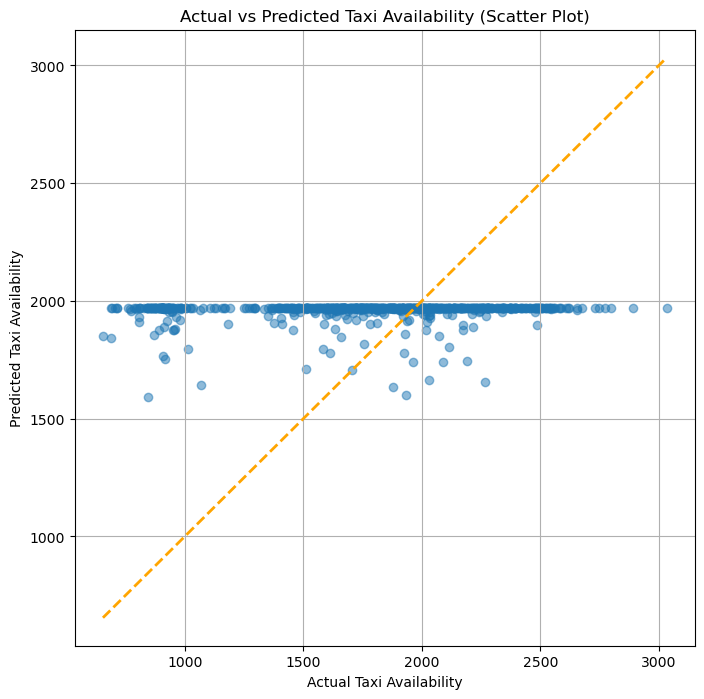

In [40]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=2, color='orange')  
plt.xlabel('Actual Taxi Availability')
plt.ylabel('Predicted Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Scatter Plot)')
plt.grid(True)
plt.show()


### Modelling Relationship Between Taxi Availability & UV Index

In [41]:
uv_july = pd.read_csv('UV_index_July_2024.csv')
uv_july['Hour'] = pd.to_datetime(uv_july['Hour'])

uv_august = pd.read_csv('UV_index_August_2024.csv')
uv_august['Hour'] = pd.to_datetime(uv_august['Hour'])

taxi_july = pd.read_csv('july_2024_taxi_availability_interpolated.csv')
taxi_july['Timestamp'] = pd.to_datetime(taxi_july['Timestamp'])

taxi_august = pd.read_csv('august_2024_taxi_availability_interpolated.csv')
taxi_august['Timestamp'] = pd.to_datetime(taxi_august['Timestamp'])

In [42]:
X_train = np.array(uv_july['UV Index']).reshape(-1, 1)
X_test = np.array(uv_august['UV Index']).reshape(-1, 1)
y_train = np.array(taxi_july['Taxi Availability']).reshape(-1, 1)
y_test = np.array(taxi_august['Taxi Availability']).reshape(-1, 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [43]:
mlp = MLPRegressor(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)], 
    'activation': ['relu', 'tanh'],                           
    'solver': ['adam', 'sgd'],                               
    'learning_rate_init': [0.001, 0.01, 0.1]                  
}

In [44]:
grid_search = GridSearchCV(
    MLPRegressor(max_iter=500, random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10
)

grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_mlp = grid_search.best_estimator_

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.1, 'solver': 'sgd'}


In [45]:
print("Best parameters:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_
y_pred = scaler.inverse_transform(best_mlp.predict(X_test_scaled).reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test data:", mse)
r2 = r2_score(y_test, y_pred)
print("R^2 Score:",r2)

Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.1, 'solver': 'sgd'}
Mean Squared Error on test data: 231815.91984503958
R^2 Score: 0.009763935549505498


In [46]:
pearson_corr_uv, _ = pearsonr(y_test.ravel(), y_pred.ravel())
spearman_corr_uv, _ = spearmanr(y_test.ravel(), y_pred.ravel())

print("UV Index Dataset:")
print("Pearson Correlation:", pearson_corr_uv)
print("Spearman Correlation:", spearman_corr_uv)

UV Index Dataset:
Pearson Correlation: 0.11465626816954234
Spearman Correlation: 0.11828926470564119


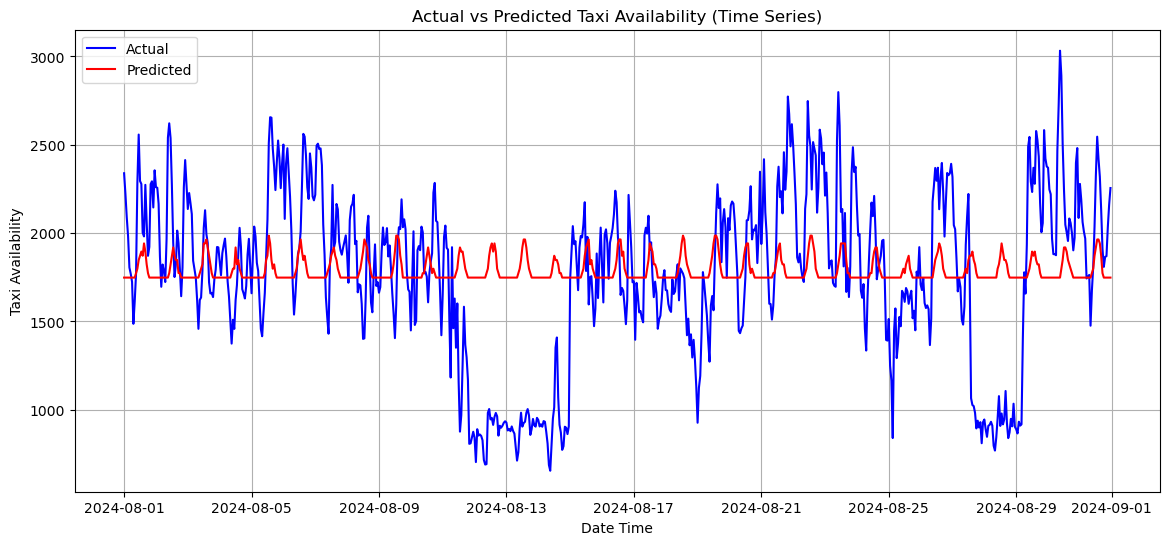

In [47]:
plt.figure(figsize=(14, 6))
plt.plot(taxi_august['Timestamp'], y_test, label='Actual', color='blue')
plt.plot(taxi_august['Timestamp'], y_pred, label='Predicted', color='red')
plt.xlabel('Date Time')
plt.ylabel('Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Time Series)')
plt.legend()
plt.grid(True)
plt.show()

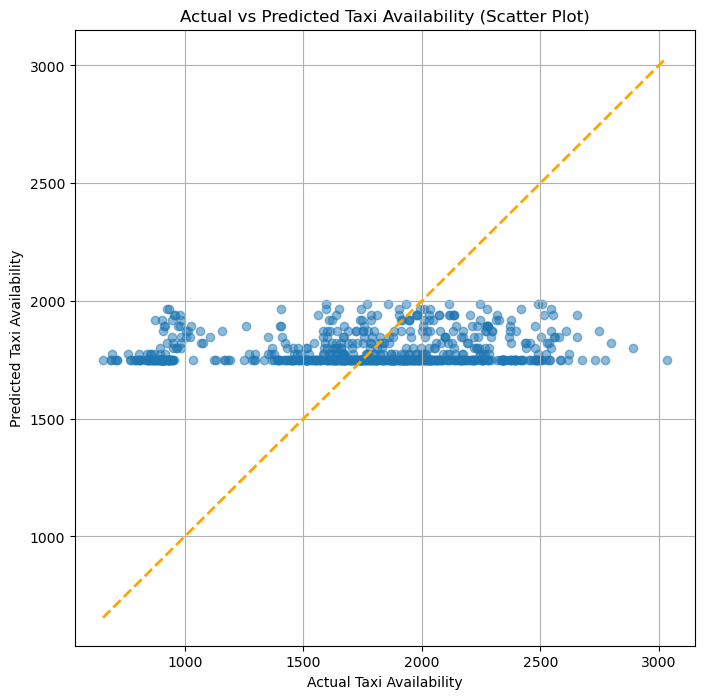

In [48]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=2, color='orange')  
plt.xlabel('Actual Taxi Availability')
plt.ylabel('Predicted Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Scatter Plot)')
plt.grid(True)
plt.show()

### Modelling Relationship Between Taxi Availability & Carpark Availabilty

In [49]:
carpark_july = pd.read_csv('july_2024_carpark_availability_interpolated.csv')
carpark_july['Timestamp'] = pd.to_datetime(carpark_july['Timestamp'], dayfirst=True)

carpark_august = pd.read_csv('august_2024_carpark_availability_interpolated.csv')
carpark_august['Timestamp'] = pd.to_datetime(carpark_august['Timestamp'], dayfirst=True)

taxi_july = pd.read_csv('july_2024_taxi_availability_interpolated.csv')
taxi_july['Timestamp'] = pd.to_datetime(taxi_july['Timestamp'])

taxi_august = pd.read_csv('august_2024_taxi_availability_interpolated.csv')
taxi_august['Timestamp'] = pd.to_datetime(taxi_august['Timestamp'])

In [50]:
X_train = np.array(carpark_july['Average Availability']).reshape(-1, 1)
X_test = np.array(carpark_august['Average Availability']).reshape(-1, 1)
y_train = np.array(taxi_july['Taxi Availability']).reshape(-1, 1)
y_test = np.array(taxi_august['Taxi Availability']).reshape(-1, 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [51]:
mlp = MLPRegressor(max_iter=500, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)], 
    'activation': ['relu', 'tanh'],                           
    'solver': ['adam', 'sgd'],                               
    'learning_rate_init': [0.001, 0.01, 0.1]                  
}

In [52]:
grid_search = GridSearchCV(
    MLPRegressor(max_iter=1000, random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10
)

grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_mlp = grid_search.best_estimator_

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.1, 'solver': 'adam'}


In [53]:
print("Best parameters:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_
y_pred = scaler.inverse_transform(best_mlp.predict(X_test_scaled).reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test data:", mse)
r2 = r2_score(y_test, y_pred)
print("R^2 Score:",r2)

Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.1, 'solver': 'adam'}
Mean Squared Error on test data: 309045.3787051454
R^2 Score: -0.32013314594685394


In [54]:
pearson_corr_carpark, _ = pearsonr(y_test.ravel(), y_pred.ravel())
spearman_corr_carpark, _ = spearmanr(y_test.ravel(), y_pred.ravel())

print("Carpark Availability Dataset:")
print("Pearson Correlation:", pearson_corr_carpark)
print("Spearman Correlation:", spearman_corr_carpark)

Carpark Availability Dataset:
Pearson Correlation: 0.08093454638462602
Spearman Correlation: 0.10189240615640403


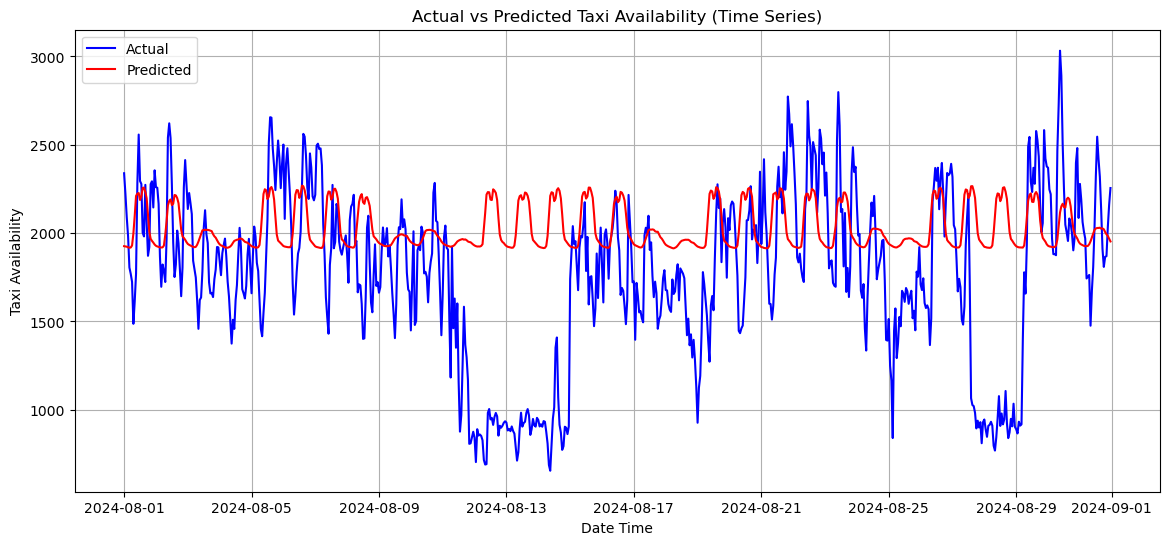

In [55]:
plt.figure(figsize=(14, 6))
plt.plot(taxi_august['Timestamp'], y_test, label='Actual', color='blue')
plt.plot(taxi_august['Timestamp'], y_pred, label='Predicted', color='red')
plt.xlabel('Date Time')
plt.ylabel('Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Time Series)')
plt.legend()
plt.grid(True)
plt.show()

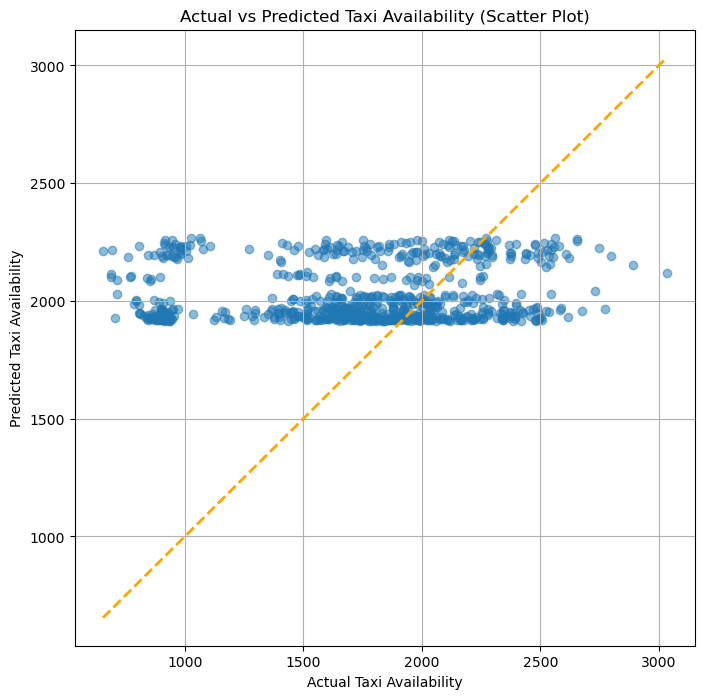

In [56]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=2, color='orange')  
plt.xlabel('Actual Taxi Availability')
plt.ylabel('Predicted Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Scatter Plot)')
plt.grid(True)
plt.show()

## 3. Developing A Model to Predict Taxi Availability using 3 Datasets

In [58]:
uv_july = pd.read_csv('UV_index_July_2024.csv')
uv_july['Hour'] = pd.to_datetime(uv_july['Hour'])

uv_august = pd.read_csv('UV_index_August_2024.csv')
uv_august['Hour'] = pd.to_datetime(uv_august['Hour'])

carpark_july = pd.read_csv('july_2024_carpark_availability_interpolated.csv')
carpark_july['Timestamp'] = pd.to_datetime(carpark_july['Timestamp'], dayfirst=True)

carpark_august = pd.read_csv('august_2024_carpark_availability_interpolated.csv')
carpark_august['Timestamp'] = pd.to_datetime(carpark_august['Timestamp'], dayfirst=True)

rainfall_july = pd.read_csv('july_rainfall_data.csv')
rainfall_july['timestamp'] = pd.to_datetime(rainfall_july['timestamp'])

rainfall_august = pd.read_csv('august_rainfall_data.csv')
rainfall_august['timestamp'] = pd.to_datetime(rainfall_august['timestamp'])

taxi_july = pd.read_csv('july_2024_taxi_availability_interpolated.csv')
taxi_july['Timestamp'] = pd.to_datetime(taxi_july['Timestamp'])

taxi_august = pd.read_csv('august_2024_taxi_availability_interpolated.csv')
taxi_august['Timestamp'] = pd.to_datetime(taxi_august['Timestamp'])

In [59]:
X_train = np.column_stack((carpark_july['Average Availability'], rainfall_july['total_hourly_rainfall'], uv_july['UV Index']))
X_test = np.column_stack((carpark_august['Average Availability'], rainfall_august['total_hourly_rainfall'], uv_august['UV Index']))
y_train = np.array(taxi_july['Taxi Availability']).reshape(-1, 1)
y_test = np.array(taxi_august['Taxi Availability']).reshape(-1, 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [60]:
mlp = MLPRegressor(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)], 
    'activation': ['relu', 'tanh'],                           
    'solver': ['adam', 'sgd'],                               
    'learning_rate_init': [0.001, 0.01, 0.1]                  
}

In [61]:
grid_search = GridSearchCV(
    MLPRegressor(max_iter=500, random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10
)

grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_mlp = grid_search.best_estimator_

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}


In [62]:
print("Best parameters:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_
y_pred = scaler.inverse_transform(best_mlp.predict(X_test_scaled).reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test data:", mse)
r2 = r2_score(y_test, y_pred)
print("R^2 Score:",r2)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
Mean Squared Error on test data: 262615.70505761734
R^2 Score: -0.12180191253897377


In [63]:
pearson_corr_combined, _ = pearsonr(y_test.ravel(), y_pred.ravel())
spearman_corr_combined, _ = spearmanr(y_test.ravel(), y_pred.ravel())

print("Combined Model (Rainfall, UV, Carpark Availability):")
print("Pearson Correlation:", pearson_corr_combined)
print("Spearman Correlation:", spearman_corr_combined)

Combined Model (Rainfall, UV, Carpark Availability):
Pearson Correlation: 0.12256258281013496
Spearman Correlation: 0.1585831712961595


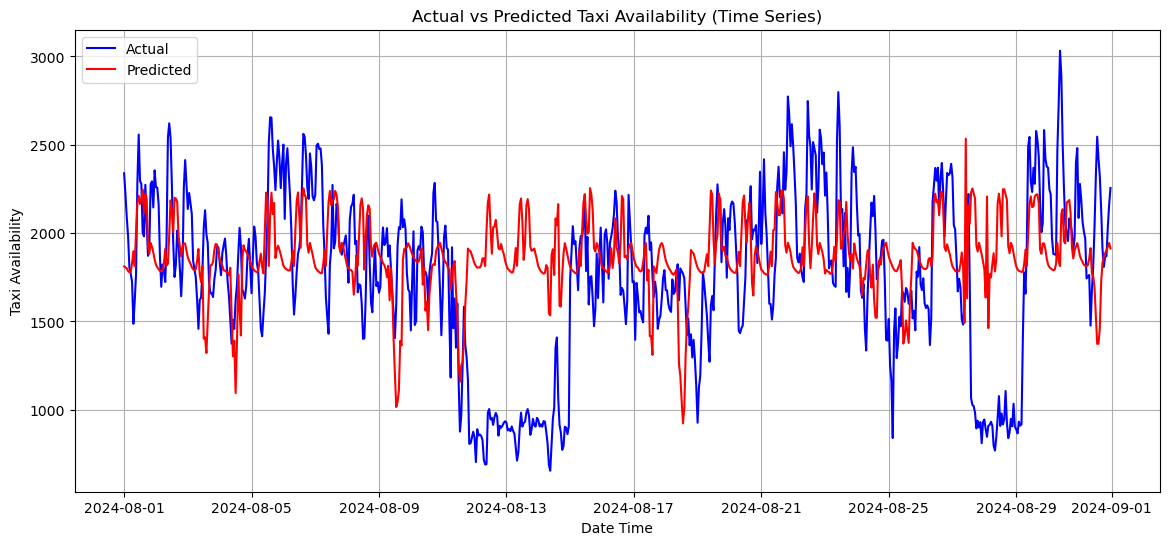

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(taxi_august['Timestamp'], y_test, label='Actual', color='blue')
plt.plot(taxi_august['Timestamp'], y_pred, label='Predicted', color='red')
plt.xlabel('Date Time')
plt.ylabel('Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Time Series)')
plt.legend()
plt.grid(True)
plt.show()

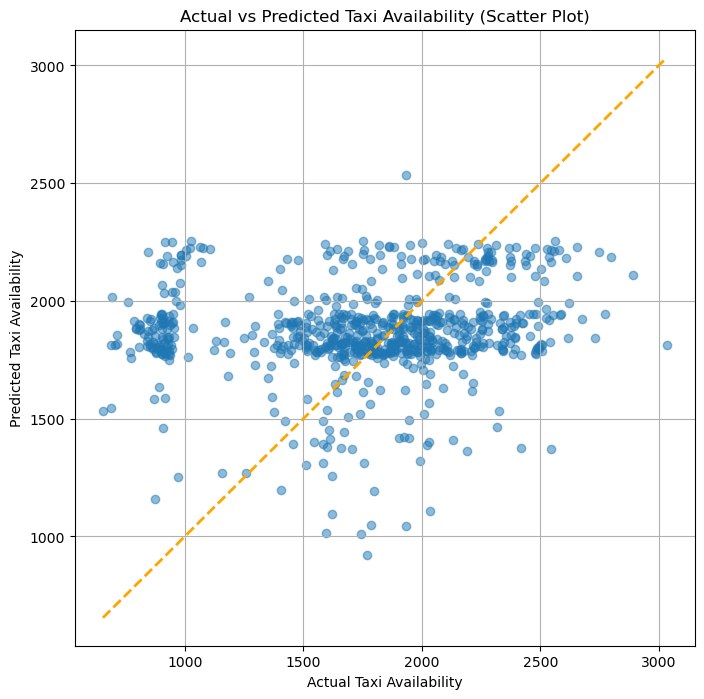

In [66]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=2, color='orange')  
plt.xlabel('Actual Taxi Availability')
plt.ylabel('Predicted Taxi Availability')
plt.title('Actual vs Predicted Taxi Availability (Scatter Plot)')
plt.grid(True)
plt.show()

## Question 3.2

A practical action based on the insights from the analysis is to develop a real-time taxi availability and demand forecasting system that integrates rainfall, UV index, and carpark availability data. This system can be implemented as both a public mobile application and a backend tool for taxi operators to optimize services.

The mobile app would provide commuters with real-time updates on taxi availability and demand in their vicinity. During adverse weather events, such as rain or high UV levels, users could receive alerts about areas with higher taxi concentrations, reducing wait times and improving trip planning. For taxi operators, the system could assist in optimizing fleet distribution by forecasting demand surges in specific areas, allowing proactive deployment of taxis to high-demand locations. This would minimize idle times, increase driver earnings, and enhance service efficiency.

The system also contributes to sustainability by reducing unnecessary cruising, thereby lowering fuel consumption and carbon emissions. Furthermore, it aligns with Singapore’s Smart Nation vision by leveraging data-driven technology to address urban mobility challenges. Scalable to other urbanized cities, this initiative provides a template for improving transport efficiency globally while addressing commuter needs, enhancing environmental sustainability, and supporting urban resilience.